In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from ipywidgets import interactive, fixed

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

# Non-harmonic distortion in a quantized sinusoid (Tsividis' Paradox)

This notebook tries to get an experimental sense of the non-harmonic distortion incurred when sampling a sinusoid with a low-rate quantizer. 


## Quantization

The following function implements quatization over the $[-1, 1]$ range using $N$ uniform quantization intervals; quantization intervals are half closed on the minimum value. The input is truncated outside of the quantization range.

When $N$ is even, the quantizer is a _mid-riser_, that is, zero is quantized to the first positive quantization level. Conversely, when $N$ is odd, the quantizer is a deadzone quantizer (zero is quantized to zero). 

In [3]:
def quantize(x, M):
    if M == 0:
        return x
    elif M % 2 == 0:
        # using a mid-riser quantizer
        M = M / 2
        k = np.floor(x * M)
        k = np.maximum(np.minimum(k, M-1), -M)
        return (k + 0.5) / M
    else:
        # using a deadzone quantizer
        k = np.round(np.abs(x) * M / 2)
        k = np.minimum((M - 1) / 2, k)
        return (np.sign(x) * k / M * 2 )

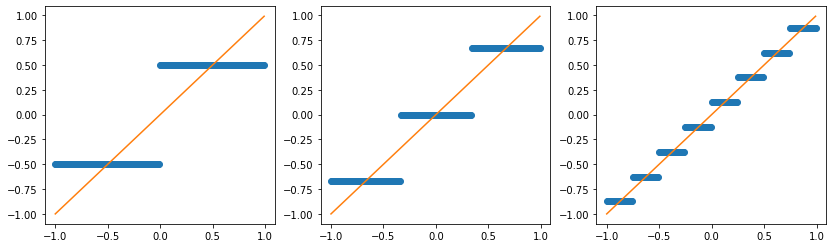

In [4]:
x = np.arange(-1, 1, .01)

plt.subplot(1, 3, 1)    
plt.plot(x, quantize(x,2), 'o');
plt.plot(x,x);

plt.subplot(1, 3, 2)    
plt.plot(x, quantize(x,3), 'o');
plt.plot(x,x);

plt.subplot(1, 3, 3)    
plt.plot(x, quantize(x,8), 'o');
plt.plot(x,x);

## Starting to spot the non-harmonic distortion

Assume you have a pure sinusoid at frequency $f$, sampled at $F_s$ Hz and assume that the frequency of the sinusoid is a fractional multiple of the sampling frequency, that is, $f = \frac{A}{B}F_s$. The discrete-time sinusoids will be of the form 

$$
    x[n] = \sin\left(\frac{2\pi}{B}{A}n\right).
$$

With $B$ a prime number, the discrete-time sinusoid will be periodic with period $B$ and will span $A$ cycles over this interval; its Fourier representation will be a $B$-point DFS and the DFS will contain harmonic lines at all indices multiple of $A$. We are interested in the values of the DFS in the _other_ bins.


Since the effect was originally remarked in conjunction with a low-rate sampling of the piccolo opening melody in Ravel's Bolero, let's first choose a ratio that brings us in that territory. By picking, say, $B=257$, we obtain a base frequency corresponding approximately to $F_3$. With $A=3$ we obtain $C_5$, which is just below the lowest note of a piccolo, and with $A=5$ we get to the top of the musically reasonable range for the piccolo. 


The following function shows the original and quantized sinusoid over $B$ samples, the first half of the normalized DFS coefficients and the non-harmonic components (i.e. the DFS coefficients not at multiples of the harmonic base frequency).

In [5]:
def show_nhd(A=5, B=257, levels=2):
    x = np.sin((2 * np.pi / B) * A * np.arange(0, B))
    qx = quantize(x, levels)
    ft = np.abs(np.fft.fft(qx))[:int(np.ceil(B/2))] / B
    nhd = np.copy(ft)
    # zero out harmonic components to highlight non-harmonic content
    nhd[::A] = 0
    
    plt.subplot(1, 2, 1)    
    plt.plot(x);
    plt.plot(qx);
    plt.title('signal')
    
    plt.subplot(1, 2, 2)    
    plt.stem(ft, use_line_collection=True)
    plt.title('DFS')
    
    plt.figure()
    plt.stem(nhd, use_line_collection=True)
    plt.ylim(0, 0.03)
    plt.title('non-harmonic components')

In [6]:
v = interactive(show_nhd, levels=(2,128), A=(1, 11), B=fixed(257))
display(v)

interactive(children=(IntSlider(value=5, description='A', max=11, min=1), IntSlider(value=2, description='leve…

## Searching for the worst case

In order to get a sense for the worst case of non-harmonic distortion, we can try to search over a large number of $A/B$ ratios between $0$ and $1/2$. Interestingly, the sequence of _non-reducible_ fractions in the unit interval with denominator smaller or equal to $N$  is known as the [**Farey sequence**](https://en.wikipedia.org/wiki/Farey_sequence) of order $N$. Even more interestingly, the algorithm to generate a Farey sequence of any order is extremely simple:

In [7]:
def farey_sequence(n):
    """Build the order-N Farey sequence up to 1/2."""
    farey = []
    (a, b, c, d) = (0, 1, 1, n)
    while (c <= n):
        k = (n + b) // d
        (a, b, c, d) = (c, d, k * c - a, k * d - b)
        farey.append((a, b))
        if a/b >= 0.5:
            break
    return farey

We can plot the element of the sequence and verify the well-known counterintuitive patterns that the rationals produce on the real line

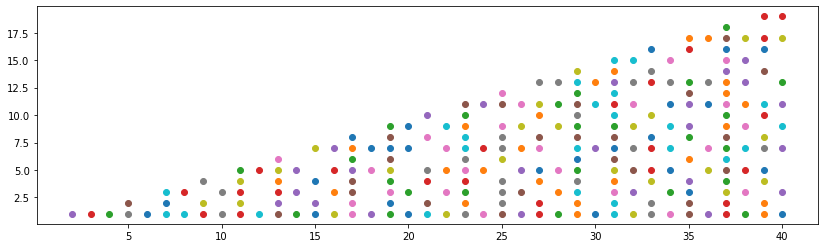

In [8]:
for (a, b) in farey_sequence(40):
    plt.plot(b, a, 'o')

With this, we can try to find the maximum value of the non-harmonic distortion over a wider range of ratios:

In [9]:
def find_nhd_peaks(N, levels=2):
    max_value = (0, 0, 0)
    for (A, B) in farey_sequence(N):
        qx = quantize(np.sin((2 * np.pi / B) * A * np.arange(0, B)), levels)
        fd = np.abs(np.fft.fft(qx))[:int(np.ceil(B/2))] / B
        fd[::A] = 0
        k = np.argmax(fd)
        plt.scatter(B, fd[k])
        if fd[k] > max_value[0]:
            max_value = (fd[k], A, B)
    plt.title(f'max value is {max_value[0]}, frequency {max_value[1]}/{max_value[2]}')

Running the algorithm for $N>100$ takes a long time (Farey sequences grow with $N^2$). For two-level quantization, if you are patient, you get a picture like this:

![title](nhd.png)

Clearly the interesting stuff happens for $N$ small, so let's concentrate on that. Let's start with 1 bit per sample

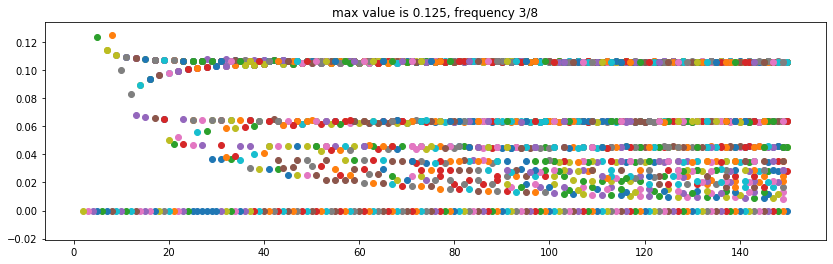

In [24]:
find_nhd_peaks(150, 2)

If we increase the number of bits per sample, the pattern changes completely...

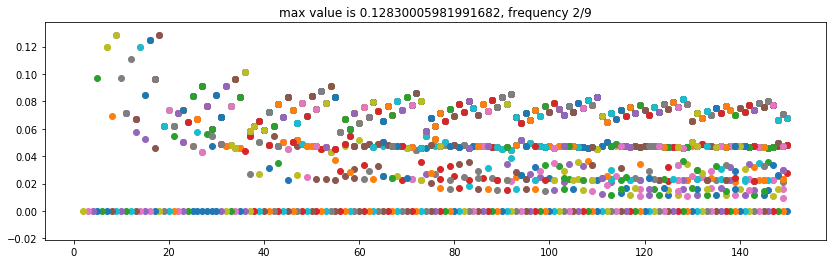

In [22]:
find_nhd_peaks(150, 3)

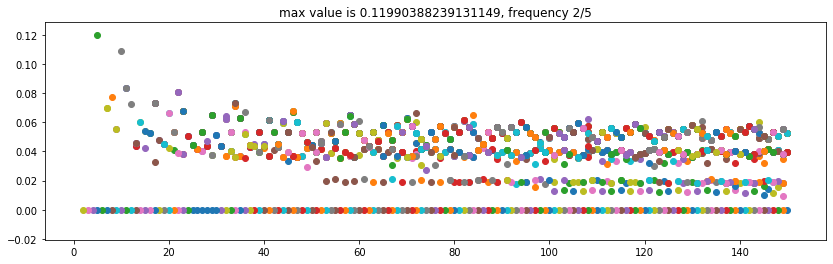

In [23]:
find_nhd_peaks(150, 4)

and, of course, as the quantization becomes finer, the non-harmonic components become negligible

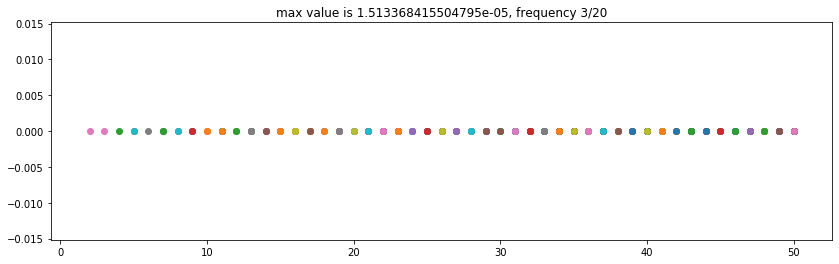

In [13]:
find_nhd_peaks(50, 32768)

## How does it sound?

So, it looks like the worst we can do is sample a sinusoid at normalized frequency $3/8$ with one bit per sample. So, hold on to your seat because this is going to sound weird...

In [16]:
def test_nhd(fs=16000, levels=2, duration=3, B=8, A=3):
    return IPython.display.Audio(quantize(np.sin((2 * np.pi / B) * A * np.arange(0, duration * fs)), levels), rate=fs)

In [40]:
test_nhd(duration=60)

Let's try and change the sampling frequency

In [18]:
test_nhd(fs=32000)

And finally, let's verify that this is indeed because of quantization...

In [19]:
test_nhd(fs=8000, levels=32768)

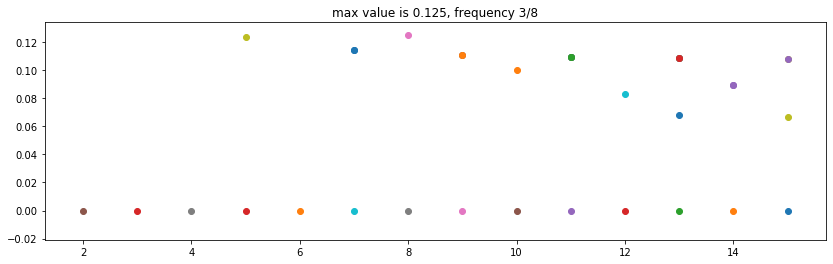

In [25]:
find_nhd_peaks(15, 2)

In [30]:
v = interactive(show_nhd, levels=(2,128), A=(1, 11), B=(1,150))
display(v)

interactive(children=(IntSlider(value=5, description='A', max=11, min=1), IntSlider(value=150, description='B'…

In [31]:
def find_nhd_peaks2(N, levels=2):
    max_value = (0, 0, 0)
    for (A, B) in farey_sequence(N):
        qx = quantize(np.sin((2 * np.pi / B) * A * np.arange(0, B)), levels)
        fd = np.abs(np.fft.fft(qx))[:int(np.ceil(B/2))] / B
        fd[::A] = 0
        k = np.argmax(fd)
        plt.scatter(B/A, fd[k])
        if fd[k] > max_value[0]:
            max_value = (fd[k], A, B)
    plt.title(f'max value is {max_value[0]}, frequency {max_value[1]}/{max_value[2]}')

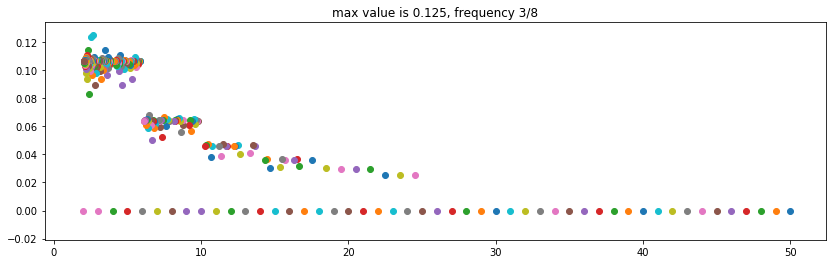

In [37]:
find_nhd_peaks2(50, 2)

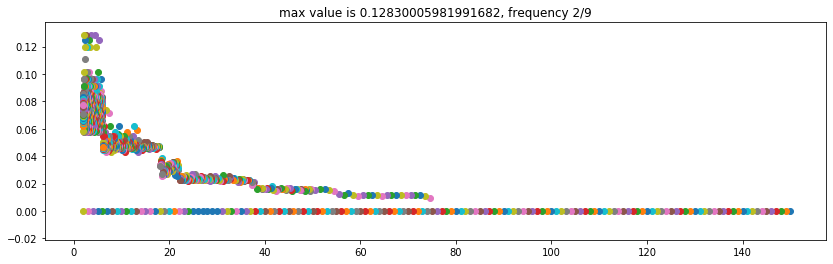

In [33]:
find_nhd_peaks2(150, 3)

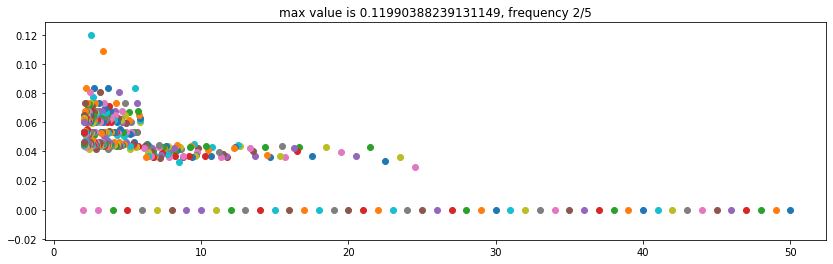

In [36]:
find_nhd_peaks2(50, 4)